##  A 2-Hidden Layer Architecture
What is happening here?
    [1] A traditional ANN model.
    [2] Import and preprocessing data. The dataset is split into training and testing sets. Then, a validation set allows monitoring the model's performance on unseen data during training, which helps in early stopping and preventing overfitting.
    [3] Create a neural network model with specific hidden layer and the model uses the Sequential API from Keras, starting with an input layer, followed by a dense (fully connected) hidden layer with ReLU activation, and then an output layer with linear activation (for regression tasks).
    [4] Model Training and Evaluation: run over a range of different number of neurons (from 20 to 80 with step of 5) to tune the model's hyperparameters.
    For each configuration: The model is trained on the training data for 150 epochs, with validation data used for validation during training.
    Performance metrics such as R-squared, RMSE (Root Mean Squared Error), and MAE (Mean Absolute Error) are computed on training, validation, and test sets.
    [5] Plot loss vs the number of epochs & MAE vs the number of epochs
    [6] Plot Correlation between the actual output and the predicted output with the training dataset
    [7] Plot Correlation between the actual output and the predicted output with the testing dataset
    [8] Lastly, SHAP (SHapley Additive exPlanations) values are computed to explain variable importance in the model using shap library. SHAP summary plots (shap.summary_plot) are created to show the impact of different features on the model predictions.

In [2]:
import pandas as pd 
import numpy as np                                             
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from sklearn.metrics import r2_score
import math
from matplotlib import pyplot as plt
import seaborn as sns
import shap

## Imports the data
bucklingdata = pd.read_csv("CBL_SimulationResults.csv", encoding='cp1252')
input_data = bucklingdata.drop(['Critical Buckling Load (N)','Critical Buckling Load (kN)'], axis=1)
output_data = bucklingdata['Critical Buckling Load (kN)']

## Data splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data,
                                                   test_size=0.3,
                                                    shuffle=False,
                                                    stratify=None,
                                                    random_state=42)

# For validation number input and output data
val_no = round(0.2*y_train.size)
x_val = X_train[:val_no]
y_val = y_train[:val_no]

def create_model2H(hp_layer_1, hp_layer_2):
    model = Sequential()
    model.add(Input(shape=(11,)))
    hp_activation = 'relu'
    hp_learning_rate = 0.001
    model.add(Dense(hp_layer_1, activation=hp_activation))
    model.add(Dense(hp_layer_2, activation=hp_activation))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=["mae"])
    return model

# Specify the range for neurons in the first and second hidden layers
min_neurons = 20
max_neurons = 80
step = 5

neuron_configs = []

# Generate configurations with increasing neurons in both layers
for neurons1 in range(min_neurons, max_neurons + 1, step):
    for neurons2 in range(min_neurons, max_neurons + 1, step):
        neuron_configs.append((neurons1, neurons2))
            
results = []

## Train your model for a number of epochs, with the .fit()
## Get the performance metrics for the network and the learning curves
# Iterate over each configuration of neurons
for i, (p1, p2) in enumerate(neuron_configs):
    print(f"Training model with configuration {i+1}: Hidden Layer 1={p1}, Hidden Layer 2={p2}")
    
    # Create the model for the current configuration
    model = create_model2H(p1, p2)
    
    # Fit the model
    history = model.fit(X_train, y_train, epochs=150,
                        validation_data=(x_val, y_val), batch_size=32,
                        verbose=0)
    
    # Evaluate the model on training, validation, and test sets
    trainmse, trainmae = model.evaluate(X_train, y_train, verbose=0)
    valmse, valmae = model.evaluate(x_val, y_val, verbose=0)
    testmse, testmae = model.evaluate(X_test, y_test, verbose=0)
    
    # Predictions for R-squared calculation
    train_pred = model.predict(X_train)
    val_pred = model.predict(x_val)
    test_pred = model.predict(X_test)
    
    # Calculate R-squared scores
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Store the evaluation metrics in a DataFrame
    result_df = pd.DataFrame({
        'Configuration': i + 1,
        'Neurons_1HL': p1,
        'Neurons_2HL': p2,
        'Train R2': train_r2,
        'Val R2': val_r2,
        'Test R2': test_r2,
        'Train RMSE': math.sqrt(trainmse),
        'Val RMSE': math.sqrt(valmse),
        'Test RMSE': math.sqrt(testmse),
        'Train MAE': trainmae,
        'Val MAE': valmae,
        'Test MAE': testmae
    }, index=[0])
    
    results.append(result_df)

# Concatenate all results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Save the results to an Excel file
results_df.to_excel('2HL_Neurons_Network_Results_TTS_V1.xlsx', index=False)
print()
print("------------Congrats! You have successfully save the results to 2HL_Neurons_Network_Results_TTS_V1------------")

Training model with configuration 1: Hidden Layer 1=20, Hidden Layer 2=20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training model with configuration 2: Hidden Layer 1=20, Hidden Layer 2=25
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training model with configuration 3: Hidden Layer 1=20, Hidden Layer 2=30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training model with configuration 4: Hidden Layer 1=20, Hidden Layer 2=35
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training model with configuration 5: Hidden Layer 1=20, Hidden Layer 2=40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
Training model with configuration 6: Hidden

### loss vs the number of epochs & MAE vs the number of epochs

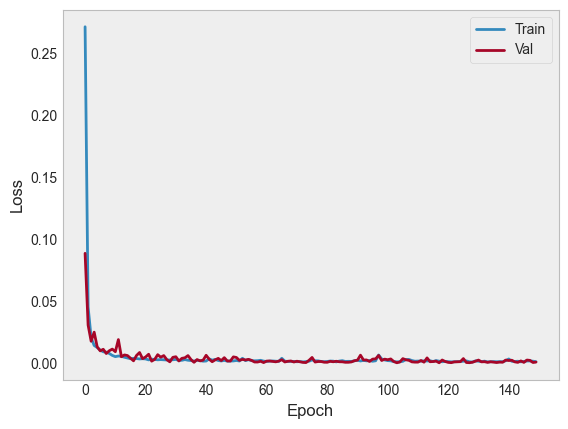

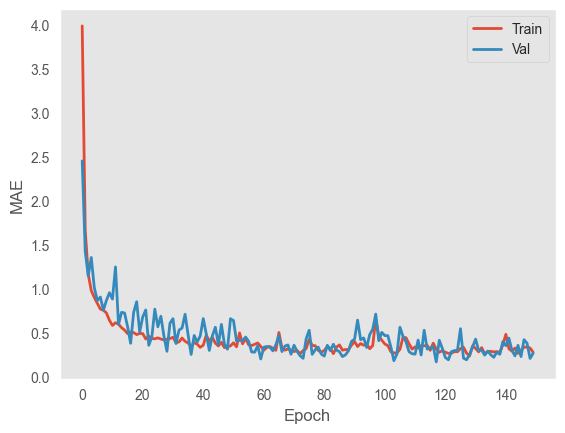

In [3]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.style.use('bmh')
  plt.grid(False)
  plt.plot(loss, linewidth=2)
  plt.plot(val_loss, linewidth=2)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

def plot_mae(mae,val_mae):
  plt.figure()
  plt.style.use('ggplot')
  plt.grid(False)
  plt.plot(mae, linewidth=2)
  plt.plot(val_mae, linewidth=2)
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

train_loss = (np.array(history.history["loss"]))/100
val_loss = np.array((history.history["val_loss"]))/100

plot_loss(train_loss, val_loss)
plot_mae(history.history["mae"], history.history["val_mae"])

### Correlation between the actual output and the predicted output with the training dataset

[]

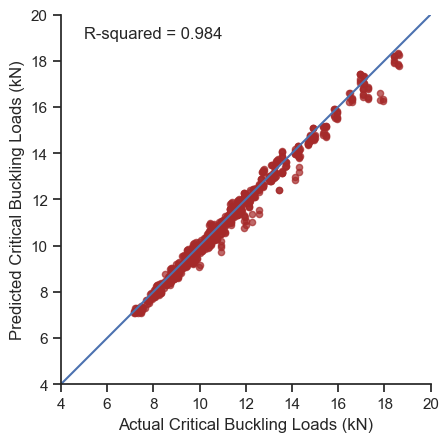

In [4]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
a = plt.axes(aspect='equal')
plt.scatter(y_train, train_pred, s = 20, alpha=0.7, c = 'brown')
plt.xlabel('Actual Critical Buckling Loads (kN)')
plt.ylabel('Predicted Critical Buckling Loads (kN)')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_train, train_pred)), (5, 19))
plt.xlim([4, 20])
plt.ylim([4, 20])
plt.plot([4, 20], [4, 20])
plt.plot()

### Correlation between the actual output and the predicted output with the testing dataset

[]

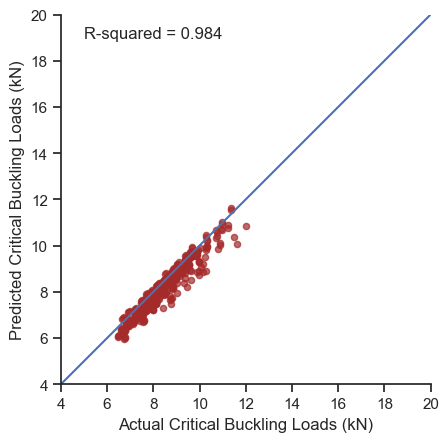

In [5]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_pred, s = 20, alpha=0.7, c = 'brown')
plt.xlabel('Actual Critical Buckling Loads (kN)')
plt.ylabel('Predicted Critical Buckling Loads (kN)')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_train, train_pred)), (5, 19))
plt.xlim([4, 20])
plt.ylim([4, 20])
plt.plot([4, 20], [4, 20])
plt.plot()

## Variable importance SHAP plot

In [6]:
### VARIABLE IMPORTANCE
# See more here: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/bar.html
features = ["Number of holes, nh", "Web-post width, WP (mm)",  "Web opening diameter, Do (mm)",  "Ply 1 (ø)", "Ply 2 (ø)", "Ply 3 (ø)", "Ply 4 (ø)", "Ply 5 (ø)", "Ply 6 (ø)", "Ply 7 (ø)", "Ply 8 (ø)"]

# Create a SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model, shap.sample(X_train, 5))

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Reshape shap_values to remove the last dimension
shap_values_reshaped = shap_values.reshape(X_test.shape)  # Assuming X_test.shape is (389, 11)


  0%|          | 0/389 [00:00<?, ?it/s]

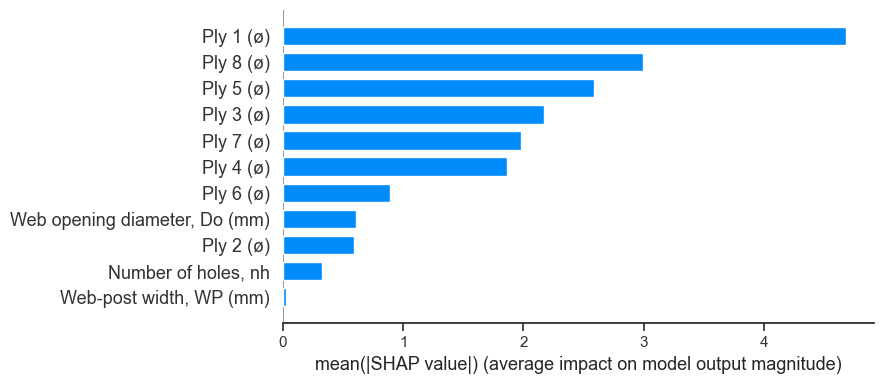

In [7]:
# Visualize feature importances using bar plot
shap.summary_plot(shap_values_reshaped, X_test, feature_names=features, plot_type="bar", plot_size=(9,4))
plt.show()

In [ ]:
### VARIABLE IMPORTANCE
# See more here: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/bar.html
features = ["Number of holes, nh", "Web-post width, WP (mm)",  "Web opening diameter, Do (mm)",  "Ply 1 (ø)", "Ply 2 (ø)", "Ply 3 (ø)", "Ply 4 (ø)", "Ply 5 (ø)", "Ply 6 (ø)", "Ply 7 (ø)", "Ply 8 (ø)"]

# Create a SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model, X_train)

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Reshape shap_values to remove the last dimension
shap_values_reshaped = shap_values.reshape(X_test.shape)  # Assuming X_test.shape is (389, 11)

# Visualize feature importances using bar plot
shap.summary_plot(shap_values_reshaped, X_test, feature_names=features, plot_type="bar")
plt.show()

Using 907 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/389 [00:00<?, ?it/s]

## Distribution density between the training and testing dataset at 70-30 split. 

In [ ]:
y_train_values = y_train.values.flatten()  # Convert to 1D array
y_test_values = y_test.values.flatten()    # Convert to 1D array

plt.figure(figsize=(6, 4))

# Plot histogram for training data
sns.histplot(y_train_values, kde=True, color='blue', label='Training Data')

# Plot histogram for testing data
sns.histplot(y_test_values, kde=True, color='red', label='Testing Data')

# Add labels and title
plt.xlabel('Critical Buckling Load (kN)')
plt.ylabel('Density')
#plt.title('Distribution of Critical Buckling Load between Training and Testing Data')
plt.legend()
plt.show()